Voiceprint Verification Model - Random Forest Implementation
Using audio_features.csv with member identification

In [1]:
#Import Libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


Load and Explore Data

In [2]:
# Load the audio features dataset
df = pd.read_csv('audio_features.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
display(df.head())

print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total Samples: {len(df)}")
print(f"Members: {df['member'].unique()}")
print(f"Number of Members: {df['member'].nunique()}")
print(f"Commands: {df['command'].unique()}")
print(f"Augmentations: {df['augmentation'].unique()}")

Dataset Shape: (40, 45)

Column Names:
['member', 'command', 'augmentation', 'filename', 'duration', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39']

First 5 rows:


,member,command,augmentation,filename,duration,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39
0,Kellen,confirm,original,Kellen-confirm.mp3,2.352018,-519.577332,83.555840,-7.111664,-6.097303,14.221958,...,2298.142091,939.573117,0.191851,0.162222,0.011676,0.010769,0.037054,0.000014,[112.34714674],3
1,Kellen,confirm,pitch_shift,Kellen-confirm.mp3,2.352018,-539.386230,81.951294,-10.157329,-3.770620,13.337985,...,2355.795879,952.119394,0.158572,0.126541,0.008463,0.007836,0.027869,0.000008,[112.34714674],3
2,Kellen,confirm,time_stretch,Kellen-confirm.mp3,1.960000,-539.576294,85.807907,-1.936857,-7.901380,14.377719,...,2434.170242,888.392448,0.157094,0.122626,0.007548,0.006624,0.024682,0.000009,[99.38401442],2
3,Kellen,confirm,add_noise,Kellen-confirm.mp3,2.352018,-291.575155,17.385597,5.426597,1.577735,1.872761,...,3308.574295,191.500625,0.312203,0.159689,0.013785,0.009314,0.037409,0.003548,[89.10290948],3
4,Kellen,confirm,speed_change,Kellen-confirm.mp3,2.613333,-534.739685,82.709023,-2.881464,-8.258417,13.247868,...,2388.823088,897.844791,0.158748,0.133412,0.007918,0.007360,0.029445,0.000009,[103.359375],3



DATASET OVERVIEW
Total Samples: 40
Members: ['Kellen' 'Hortance' 'Yvette' 'Innocente']
Number of Members: 4
Commands: ['confirm' 'approve']
Augmentations: ['original' 'pitch_shift' 'time_stretch' 'add_noise' 'speed_change']


Member Distribution Analysis


MEMBER DISTRIBUTION
member
Kellen       10
Hortance     10
Yvette       10
Innocente    10
Name: count, dtype: int64


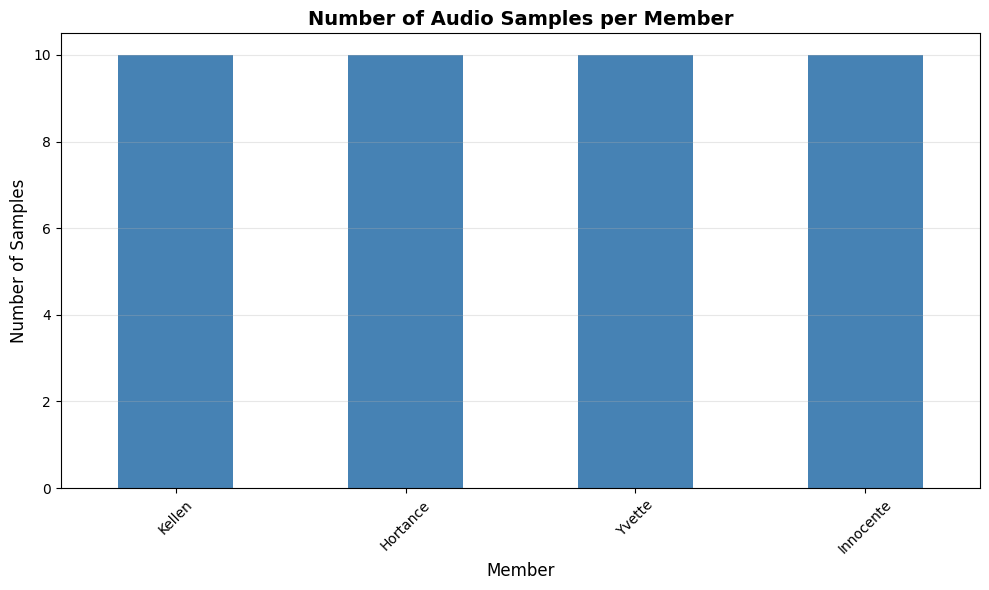


Command Distribution per Member:
command    approve  confirm
member                     
Hortance         5        5
Innocente        5        5
Kellen           5        5
Yvette           5        5


In [3]:
print("\n" + "="*60)
print("MEMBER DISTRIBUTION")
print("="*60)
member_counts = df['member'].value_counts()
print(member_counts)

# Visualize member distribution
plt.figure(figsize=(10, 6))
member_counts.plot(kind='bar', color='steelblue')
plt.title('Number of Audio Samples per Member', fontsize=14, fontweight='bold')
plt.xlabel('Member', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Command distribution per member
print("\nCommand Distribution per Member:")
print(pd.crosstab(df['member'], df['command']))

Feature Engineering - Select Audio Features

In [4]:
import numpy as np

# Select only the numeric audio features (feature_0 to feature_39)
feature_columns = [col for col in df.columns if col.startswith('feature_')]
print(f"\nTotal Audio Features: {len(feature_columns)}")
print(f"Feature columns: {feature_columns[:5]}... (showing first 5)")

# Extract features and target
X = df[feature_columns].copy()
y = df['member'].copy()

# Convert feature columns to numeric, coercing errors
for col in feature_columns:
    X[col] = pd.to_numeric(X[col].astype(str).str.strip('[]'), errors='coerce')

# Drop rows with NaN values introduced by coercion if any
original_rows = X.shape[0]
X.dropna(inplace=True)
y = y[X.index] # Align target with cleaned features

if X.shape[0] < original_rows:
    print(f"Warning: Dropped {original_rows - X.shape[0]} rows due to non-numeric feature values after conversion.")

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

# Check for missing values after conversion and dropping
print(f"\nMissing values in features after cleaning: {X.isnull().sum().sum()}")
print(f"Missing values in target after cleaning: {y.isnull().sum()}")


Total Audio Features: 40
Feature columns: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']... (showing first 5)

Feature Matrix Shape: (40, 40)
Target Shape: (40,)

Missing values in features after cleaning: 0
Missing values in target after cleaning: 0


Encode Target Labels

In [5]:
# Encode member names to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\n" + "="*60)
print("LABEL ENCODING")
print("="*60)
print("Member to Label Mapping:")
for member, label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {member} → {label}")


LABEL ENCODING
Member to Label Mapping:
  Hortance → 0
  Innocente → 1
  Kellen → 2
  Yvette → 3


Train/Test Split (Stratified)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("\n" + "="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.2f}")

# Distribution in train/test
print("\nTrain set distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nTest set distribution:")
print(pd.Series(y_test).value_counts().sort_index())


TRAIN/TEST SPLIT
Training samples: 32
Testing samples: 8
Train/Test ratio: 4.00

Train set distribution:
0    8
1    8
2    8
3    8
Name: count, dtype: int64

Test set distribution:
0    2
1    2
2    2
3    2
Name: count, dtype: int64


Feature Scaling

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")
print(f"Mean after scaling (train): {X_train_scaled.mean():.6f}")
print(f"Std after scaling (train): {X_train_scaled.std():.6f}")


✓ Features scaled using StandardScaler
Mean after scaling (train): -0.000000
Std after scaling (train): 1.000000


Train Random Forest Model

In [8]:
print("\n" + "="*60)
print("TRAINING RANDOM FOREST MODEL")
print("="*60)

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

print("✓ Random Forest model trained successfully!")


TRAINING RANDOM FOREST MODEL
✓ Random Forest model trained successfully!


Model Evaluation

In [9]:
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


PERFORMANCE METRICS
Accuracy: 1.0000
F1-Score (weighted): 1.0000
F1-Score (macro): 1.0000

Classification Report:
              precision    recall  f1-score   support

    Hortance       1.00      1.00      1.00         2
   Innocente       1.00      1.00      1.00         2
      Kellen       1.00      1.00      1.00         2
      Yvette       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



Confusion Matrix Visualization

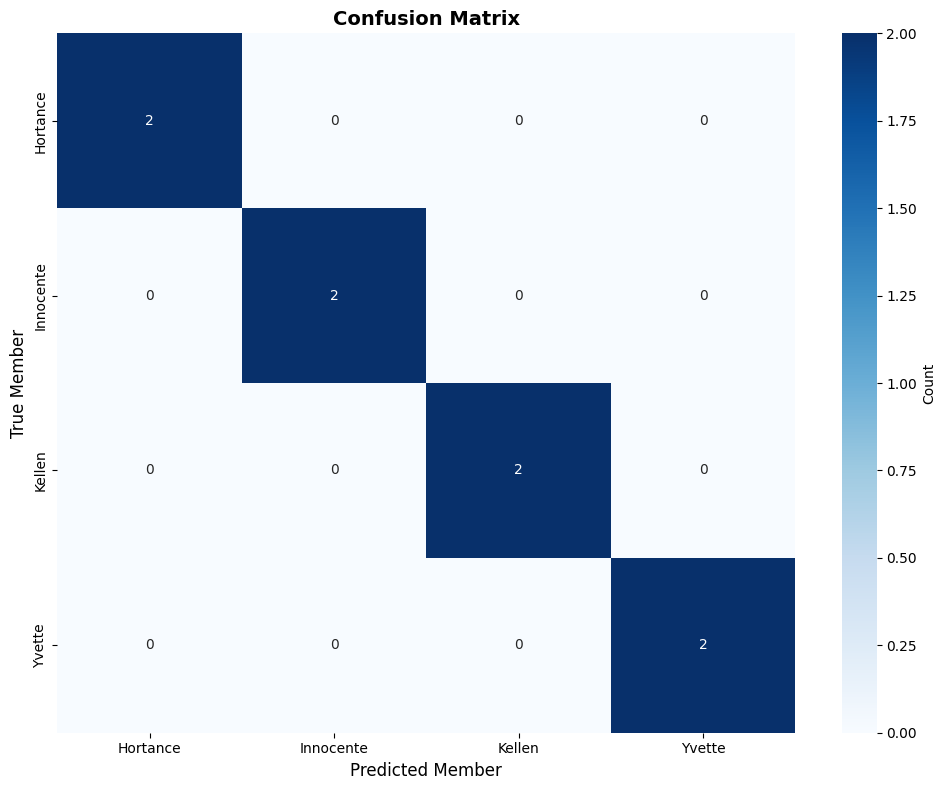

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Member', fontsize=12)
plt.ylabel('True Member', fontsize=12)
plt.tight_layout()
plt.show()

Feature Importance Analysis


TOP 15 MOST IMPORTANT FEATURES
       feature  importance
5    feature_5    0.083315
4    feature_4    0.069269
36  feature_36    0.065780
2    feature_2    0.063655
35  feature_35    0.056458
11  feature_11    0.054123
10  feature_10    0.048857
9    feature_9    0.048595
6    feature_6    0.033346
34  feature_34    0.033180
7    feature_7    0.030187
3    feature_3    0.029938
32  feature_32    0.029842
1    feature_1    0.028390
37  feature_37    0.026438


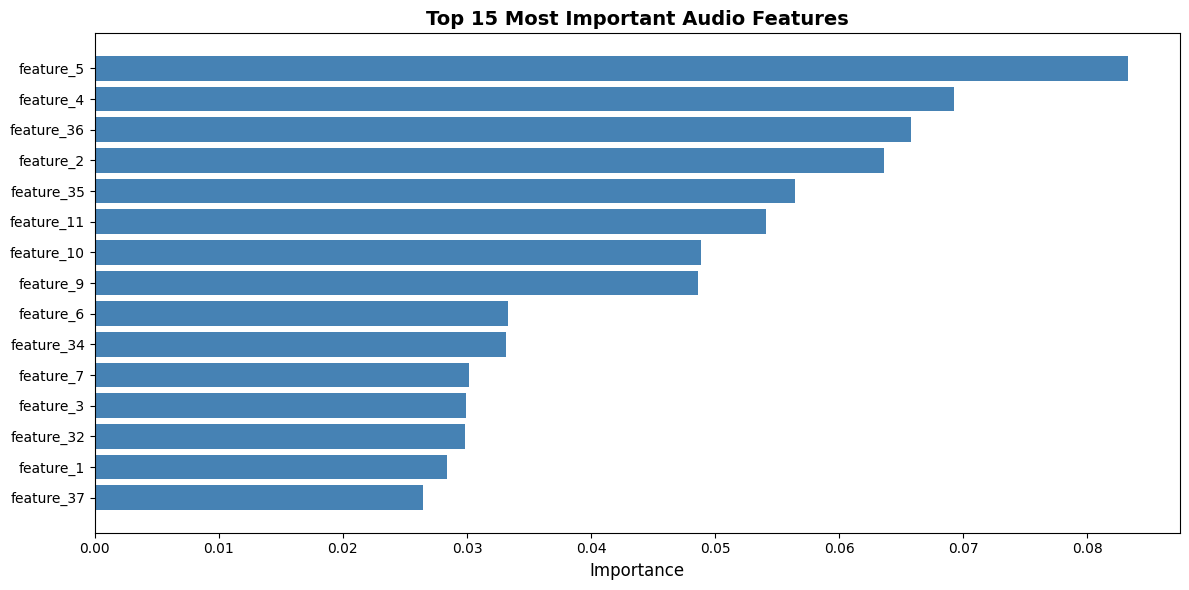

In [11]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*60)
print(feature_importance.head(15))

plt.figure(figsize=(12, 6))
plt.barh(feature_importance.head(15)['feature'],
         feature_importance.head(15)['importance'],
         color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Most Important Audio Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Save Model

In [12]:
# Save model, scaler, encoder, and feature columns
model_data = {
    'model': model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_columns': feature_columns
}

joblib.dump(model_data, 'voiceprint_model.joblib')
print(f"\n✓ Model saved to: voiceprint_model.joblib")


✓ Model saved to: voiceprint_model.joblib


Save Test Results

In [13]:
results_df = X_test.copy()
results_df['true_member'] = label_encoder.inverse_transform(y_test)
results_df['predicted_member'] = label_encoder.inverse_transform(y_pred)
results_df['correct'] = results_df['true_member'] == results_df['predicted_member']

# Add prediction probabilities
for i, member in enumerate(label_encoder.classes_):
    results_df[f'prob_{member}'] = y_pred_proba[:, i]

results_df.to_csv('voiceprint_test_results.csv', index=False)
print("✓ Test results saved to: voiceprint_test_results.csv")

print(f"\nCorrect Predictions: {results_df['correct'].sum()} / {len(results_df)}")
print(f"Incorrect Predictions: {(~results_df['correct']).sum()} / {len(results_df)}")

✓ Test results saved to: voiceprint_test_results.csv

Correct Predictions: 8 / 8
Incorrect Predictions: 0 / 8


Voice Verification Function

In [14]:
def verify_voice(audio_features, claimed_member, threshold=0.6):
    """
    Verify if audio features match the claimed member identity

    Parameters:
    - audio_features: array of 40 audio features (feature_0 to feature_39)
    - claimed_member: name of the member claiming identity (e.g., 'Kellen')
    - threshold: minimum probability required for verification (0-1)

    Returns:
    - dict with verification results
    """
    # Load model
    model_data = joblib.load('voiceprint_model.joblib')
    model = model_data['model']
    scaler = model_data['scaler']
    encoder = model_data['label_encoder']

    # Prepare features
    features = np.array(audio_features).reshape(1, -1)
    features_scaled = scaler.transform(features)

    # Predict
    predicted_label = model.predict(features_scaled)[0]
    predicted_member = encoder.inverse_transform([predicted_label])[0]

    # Get probabilities
    probs = model.predict_proba(features_scaled)[0]
    predicted_prob = probs[predicted_label]

    # Get probability for claimed member
    claimed_label = encoder.transform([claimed_member])[0]
    claimed_prob = probs[claimed_label]

    # Verification decision
    verified = (predicted_member == claimed_member and predicted_prob >= threshold)

    return {
        'verified': verified,
        'claimed_member': claimed_member,
        'predicted_member': predicted_member,
        'confidence': float(predicted_prob),
        'claimed_confidence': float(claimed_prob),
        'threshold': threshold,
        'all_probabilities': {member: float(prob) for member, prob in zip(encoder.classes_, probs)}
    }

print("✓ Voice verification function defined")

✓ Voice verification function defined


Test Voice Verification

In [15]:
print("\n" + "="*60)
print("DEMO: VOICE VERIFICATION")
print("="*60)

# Test with a sample from the test set
test_idx = 0
sample_features = X_test.iloc[test_idx].values
true_member = label_encoder.inverse_transform([y_test[test_idx]])[0]

print(f"\nTest Sample #{test_idx + 1}")
print(f"True Member: {true_member}")

# Test 1: Correct claim
print("\n--- Test 1: Claiming correct identity ---")
result = verify_voice(sample_features, true_member, threshold=0.6)
print(f"Claimed: {result['claimed_member']}")
print(f"Predicted: {result['predicted_member']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Verified: {'✓ YES' if result['verified'] else '✗ NO'}")

# Test 2: Wrong claim (if multiple members exist)
if len(label_encoder.classes_) > 1:
    wrong_member = [m for m in label_encoder.classes_ if m != true_member][0]
    print(f"\n--- Test 2: Claiming wrong identity ({wrong_member}) ---")
    result2 = verify_voice(sample_features, wrong_member, threshold=0.6)
    print(f"Claimed: {result2['claimed_member']}")
    print(f"Predicted: {result2['predicted_member']}")
    print(f"Claimed Confidence: {result2['claimed_confidence']:.4f}")
    print(f"Verified: {'✓ YES' if result2['verified'] else '✗ NO'}")

print("\n" + "="*60)
print("All probabilities for this sample:")
for member, prob in result['all_probabilities'].items():
    print(f"  {member}: {prob:.4f}")
print("="*60)


DEMO: VOICE VERIFICATION

Test Sample #1
True Member: Kellen

--- Test 1: Claiming correct identity ---


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Claimed: Kellen
Predicted: Kellen
Confidence: 0.6800
Verified: ✓ YES

--- Test 2: Claiming wrong identity (Hortance) ---
Claimed: Hortance
Predicted: Kellen
Claimed Confidence: 0.0500
Verified: ✗ NO

All probabilities for this sample:
  Hortance: 0.0500
  Innocente: 0.1000
  Kellen: 0.6800
  Yvette: 0.1700


Summary Report

In [16]:
print("\n" + "="*60)
print("PROJECT SUMMARY REPORT")
print("="*60)
print(f"Dataset: audio_features.csv")
print(f"Total Samples: {len(df)}")
print(f"Number of Members: {df['member'].nunique()}")
print(f"Members: {', '.join(df['member'].unique())}")
print(f"Audio Features: {len(feature_columns)}")
print(f"\nModel: Random Forest")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1-Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"\nModel saved as: voiceprint_model.joblib")
print(f"Results saved as: voiceprint_test_results.csv")
print("="*60)


PROJECT SUMMARY REPORT
Dataset: audio_features.csv
Total Samples: 40
Number of Members: 4
Members: Kellen, Hortance, Yvette, Innocente
Audio Features: 40

Model: Random Forest
Test Accuracy: 1.0000
Test F1-Score (weighted): 1.0000

Model saved as: voiceprint_model.joblib
Results saved as: voiceprint_test_results.csv
